## CDS Basket Option Valuation

### 1 Theory

\begin{equation}
c_{CDS}(T)=\frac{(1-R)\int_{0}^TP(0,t)\tilde{\lambda}(t)S(t)\,\mathrm{d}t}{\sum_{i=1}^n P(0,t_i)S(t_i)}
\end{equation}

Assuming piecewise constant $\lambda$ we have $\tilde{\lambda}=\lambda$
\begin{equation}
c_{CDS}(T)=\frac{(1-R)\int_{0}^TP(0,t)\tilde{\lambda}(t)S(t)\,\mathrm{d}t}{\sum_{i=1}^n P(0,t_i)S(t_i)}
\end{equation}

\begin{equation}
S(t):=\mathbb{E}\left(\exp\left(-\int_0^t \lambda(s)\,\mathrm{d}s\right)\right)=:\exp\left(-\int_0^t \tilde{\lambda}(s)\,\mathrm{d}s\right)
\end{equation}

### 2 Bootstrapping hazard rates

$c_i:=c_{CDS}(T_i)$, $p_i:=S(t_i)$
\begin{equation}
\frac{c_i}{1-R}\sum_{k=1}^n P(0,t_k)p_k=\sum_{l=1}^i P(0,T_l)p_{l-1}-\sum_{l=1}^i P(0,T_l)p_l
\end{equation}

\begin{equation}
p_i = \frac{\sum_{l=1}^i P(0,T_l)p_{l-1}-\sum_{l=1}^{i-1} P(0,T_l)p_l-\frac{c_i}{1-R}\sum_{k=1}^{n-1} P(0,t_k)p_k}{P(0,T_i)\left(1+\frac{c_i}{1-R}\right)}
\end{equation}

In [123]:
import numpy as np
from typing import List, Tuple

def bisection_search(func, low: float = 1e-10, high: float = 5.0,
                     tolerance: float = 1e-12, iters: int = 100) -> float:
    value_low, value_high = func(low), func(high)
    cnt = 0
    while value_low * value_high > 0.0 and cnt < 20:
        high *= 2.0
        value_high = func(high)
        cnt += 1
    if value_low * value_high > 0.0:
        raise RuntimeError("Could not bracket hazard in bucket")
    for _ in range(iters):
        mid = 0.5 * (low + high)
        value_mid = func(mid)
        if abs(value_mid) < tolerance or (high - low) < 1e-12:
            return mid
        if value_low * value_mid <= 0.0:
            high, value_high = mid, value_mid
        else:
            low, value_low = mid, value_mid
    return 0.5 * (low + high)


def compute_cds_legs(
    maturities: List[float],                     # T_i (years), ascending
    payment_days: np.ndarray,                   # coupon dates t_k (years), ascending
    discount_factors_payment_days: np.ndarray,  
    recovery_rate: float,
    hazard_rates: List[float]
) -> Tuple[float, float]:
    indices = np.searchsorted(payment_days, maturities)
    time_to_index = dict(zip(maturities, indices))

    deltas = [payment_days[0]] + [payment_days[k]-payment_days[k-1]
                                  for k in range(1, len(payment_days))]
    premium_leg = 0.0
    protection_leg  = 0.0
    survival_prob_prev = 1.0
    prev_time_idx = 0
    for idx, maturity in enumerate(maturities):
        prev_maturity = maturities[idx - 1] if idx > 0 else 0.0
        time_idx = time_to_index[maturity]
        hazard_rate = hazard_rates[idx]
        for k in range(prev_time_idx, time_idx + 1):  # include coupon at t_k = T_i
            payment_date = payment_days[k]
            discount = discount_factors_payment_days[k]
            delta = deltas[k]
            survival_prob = survival_prob_prev * np.exp(-hazard_rate * (payment_date - prev_maturity))
            # premium leg: coupons + AoD (trapezoid)
            accrual = 0.5 * delta * discount * (survival_prob_prev - survival_prob)
            premium_leg += delta * discount * survival_prob + accrual
            # protection leg
            protection_leg += (1.0 - recovery_rate) * discount * (survival_prob_prev - survival_prob)
        prev_time_idx = time_idx
        survival_prob_prev = survival_prob
    return premium_leg, protection_leg


def bootstrap_hazards(
    credit_spreads: List[float],                 
    maturities: np.ndarray,                     
    payment_days: np.ndarray,                   
    discount_factors_payment_days: np.ndarray,  
    recovery_rate: float                         
) -> List[float]:
    """
    Generalized CDS bootstrap (coupon grid + AoD trapezoid) with piecewise-constant hazards.
    Calls `compute_legs` during root-finding.
    Assumes each maturity T_i is present in `payment_days`.
    """
    assert len(payment_days) == len(discount_factors_payment_days)
    hazard_rates: List[float] = []

    for i, spread in enumerate(credit_spreads):
        # Build F_i(lambda_i) = spread * RPV01(T_i) - Prot(T_i),
        # where RPV01/Prot are computed by compute_legs on data up to T_i
        def F(lam_i: float) -> float:
            tmp_haz = hazard_rates + [lam_i]           # previous solved + candidate
            mats_up_to_i = maturities[: i + 1]         # only up to current maturity
            prem, prot = compute_cds_legs(
                mats_up_to_i,
                payment_days,
                discount_factors_payment_days,
                recovery_rate,
                tmp_haz
            )
            return spread * prem - prot

        lam_i = bisection_search(F)  # robust and keeps your flow
        hazard_rates.append(lam_i)

    return hazard_rates

        

### 3 The Copula

In [124]:
from scipy.stats import norm

def gaussian_copula_unif(dim: int, num_samples: int, cov_matrix: np.ndarray) -> np.ndarray:
    from scipy.stats import norm
    chol = np.linalg.cholesky(cov_matrix)
    z = np.random.randn(num_samples // 2, dim)
    z_a = np.vstack([z, -z])                 # antithetic normals
    corr_normals = z_a @ chol.T
    return norm.cdf(corr_normals)


def uniforms_to_default_times(uniforms: np.ndarray,
                              hazards: np.ndarray,
                              maturities: np.ndarray) -> np.ndarray:
    """
    uniforms:  (num_samples, num_names)  ~ U(0,1) from copula
    hazards:   (num_names, num_buckets)  piecewise-constant λ_{name, bucket}
    maturities: [T1, T2, ..., Tn]   (bucket endpoints, ascending)
    returns τ: (num_samples, num_names) default times
    """
    num_samples, num_names = uniforms.shape
    num_names_h, num_buckets = hazards.shape
    assert num_names == num_names_h
    assert num_buckets == len(maturities)

    # survival at bucket endpoints: S(0)=1, S(T_i)=exp(-∑ λ_j Δt_j)
    survival = np.ones((num_names, num_buckets + 1))
    for i in range(num_buckets):
        dt = maturities[i] - (maturities[i-1] if i > 0 else 0.0)
        survival[:, i+1] = survival[:, i] * np.exp(-hazards[:, i] * dt)

    tau = np.zeros_like(uniforms)  # will overwrite for every (s, name)

    for name in range(num_names):
        for s in range(num_samples):
            u = uniforms[s, name]
            found = False
            for i in range(num_buckets):
                # Find the bucket where S(T_i) >= u > S(T_{i+1})
                if survival[name, i+1] <= u <= survival[name, i]:
                    T_im1 = 0.0 if i == 0 else maturities[i-1]
                    S_im1 = survival[name, i]
                    lam   = hazards[name, i]
                    # Solve S(T_im1 + τ') = u  => τ' = -ln(u/S_im1)/lam
                    tau[s, name] = T_im1 - (1.0/lam) * np.log(u / S_im1)
                    found = True
                    break
            if not found:
                # u < S(T_last): default occurs AFTER the last bucket (no default by T_last)
                # Set τ at the last bucket end so τ > any basket maturity <= T_last
                tau[s, name] = maturities[-1]
    return tau


#### 3.1 The Gauss Copula

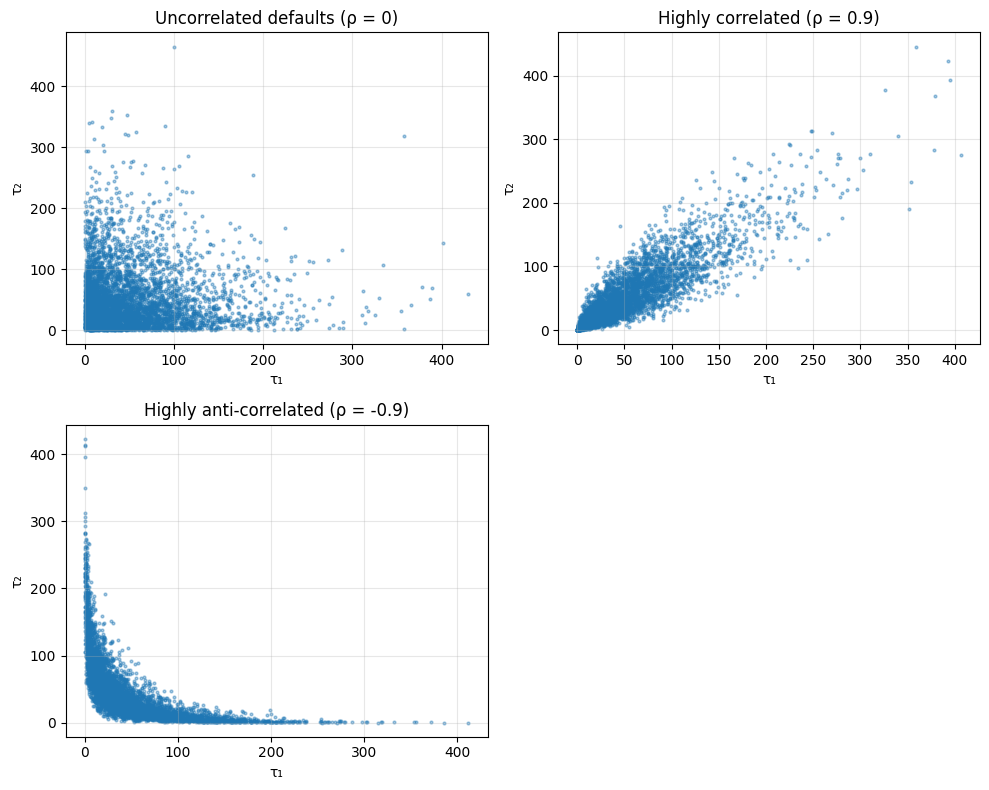

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ---------- parameters ----------
num_samples = 5000
rho_low = 0.0          # uncorrelated case
rho_corr = 0.9         # highly correlated case
rho_anticorr = -0.9  
hazard = 0.02           # same constant hazard rate for both names
# --------------------------------

def compute_2dcov_matrix(rho: float) -> np.ndarray:
    cov = np.array([[1, rho], [rho, 1]])
    return cov

def inverse_exponential(u: np.ndarray, lam: float) -> np.ndarray:
    """Inverse CDF of Exp(lam): tau = -log(1-u)/lam"""
    return -np.log(1.0 - u) / lam

# --- generate uniforms ---
sigma_low = compute_2dcov_matrix(rho_low)
sigma_corr = compute_2dcov_matrix(rho_corr)
sigma_anticorr = compute_2dcov_matrix(rho_anticorr)

U_low       = gaussian_copula_unif(dim=2, num_samples=num_samples, cov_matrix=sigma_low)
U_corr      = gaussian_copula_unif(dim=2, num_samples=num_samples, cov_matrix=sigma_corr)
U_anticorr  = gaussian_copula_unif(dim=2, num_samples=num_samples, cov_matrix=sigma_anticorr)

# --- convert to default times ---
tau_low       = inverse_exponential(U_low,      hazard)
tau_corr      = inverse_exponential(U_corr,     hazard)
tau_anticorr  = inverse_exponential(U_anticorr, hazard)

# --- plot ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].scatter(tau_low[:, 0], tau_low[:, 1], s=4, alpha=0.4)
axes[0, 0].set_title("Uncorrelated defaults (ρ = 0)")
axes[0, 0].set_xlabel("τ₁"); axes[0, 0].set_ylabel("τ₂"); axes[0, 0].grid(alpha=0.3)

axes[0, 1].scatter(tau_corr[:, 0], tau_corr[:, 1], s=4, alpha=0.4)
axes[0, 1].set_title("Highly correlated (ρ = 0.9)")
axes[0, 1].set_xlabel("τ₁"); axes[0, 1].set_ylabel("τ₂"); axes[0, 1].grid(alpha=0.3)

axes[1, 0].scatter(tau_anticorr[:, 0], tau_anticorr[:, 1], s=4, alpha=0.4)
axes[1, 0].set_title("Highly anti-correlated (ρ = -0.9)")
axes[1, 0].set_xlabel("τ₁"); axes[1, 0].set_ylabel("τ₂"); axes[1, 0].grid(alpha=0.3)

axes[1, 1].axis('off')  

plt.tight_layout()
plt.show()


### 3.2 The t-Copula

### 4 Valuation of a kth-to-default basket CDS

In [126]:
import pandas as pd
import sys
import os

# Add the parent folder (tests/) to the Python path
sys.path.append(os.path.abspath(".."))

from helpers.kaggle_data_helper import download_data_from_kaggle

HANDLE = "debashish311601/credit-default-swap-cds-prices"

#download_data_from_kaggle(handle=HANDLE)

output_path = "data/cds_data.csv"
df = pd.read_csv(output_path)
print(df.head(5))


   Unnamed: 0        Date Ticker                   Company     PX1    PX2  \
0           0  2015-01-01      A  Agilent Technologies Inc  14.850  25.05   
1           1  2015-01-02      A  Agilent Technologies Inc  14.855  25.15   
2           2  2015-01-05      A  Agilent Technologies Inc  13.455  24.96   
3           3  2015-01-06      A  Agilent Technologies Inc  15.535  24.88   
4           4  2015-01-07      A  Agilent Technologies Inc  15.215  25.50   

      PX3     PX4    PX5      PX6      PX7      PX8      PX9     PX10  
0  39.055  73.715  86.30  111.305  125.905  144.300  158.600  168.195  
1  39.160  73.600  86.40  111.510  126.100  144.375  158.775  168.375  
2  39.310  70.200  88.26  111.970  125.060  143.165  157.385  166.825  
3  39.300  72.680  91.10  116.610  130.890  150.365  165.655  175.885  
4  40.270  73.880  92.50  117.780  131.940  151.145  166.215  176.295  


In [127]:
import pandas as pd

# Select 5Y tenor (most liquid)
TENOR_COL = "PX6"  

# Select 5 highly correlated names in same sector (banking)
NAMES = [
    "JPMorgan Chase   Co",
    "Bank of America Corp",
    "Citigroup Inc",
    "Wells Fargo   Co",
    "Morgan Stanley",
]
df_sub = (
    df[df["Company"].isin(NAMES)].copy()
    .assign(Date=lambda x: pd.to_datetime(x["Date"]))
    .sort_values(["Company", "Date"])
)
px = df_sub[TENOR_COL].astype(float)
px = px.mask(px <= 0, np.nan)

# Compute correlation between daily log returns of spreads
panel = []
for name in NAMES:
    sub = df.loc[df["Company"] == name, ["Date", TENOR_COL]].copy()
    sub = sub.rename(columns={TENOR_COL: name})
    panel.append(sub.set_index("Date"))
wide = pd.concat(panel, axis=1, join="inner").sort_index()
logret = np.log(wide).diff().dropna(how="all")
cov_matrix = logret.corr().to_numpy()


print("\nCorrelation (Log Retruns of 5Y credit spreads):")
print(pd.DataFrame(cov_matrix, index=NAMES, columns=NAMES).round(3))


Correlation (Log Retruns of 5Y credit spreads):
                      JPMorgan Chase   Co  Bank of America Corp  \
JPMorgan Chase   Co                 1.000                 0.848   
Bank of America Corp                0.848                 1.000   
Citigroup Inc                       0.829                 0.859   
Wells Fargo   Co                    0.810                 0.801   
Morgan Stanley                      0.810                 0.841   

                      Citigroup Inc  Wells Fargo   Co  Morgan Stanley  
JPMorgan Chase   Co           0.829             0.810           0.810  
Bank of America Corp          0.859             0.801           0.841  
Citigroup Inc                 1.000             0.813           0.874  
Wells Fargo   Co              0.813             1.000           0.799  
Morgan Stanley                0.874             0.799           1.000  


In [138]:
# Map column names to maturities (in years)
TENOR_MAP = {
    "PX1": 0.5, "PX2": 1.0, "PX3": 2.0, "PX4": 3.0, "PX5": 4.0,
    "PX6": 5.0, "PX7": 7.0, "PX8": 10.0, "PX9": 15.0, "PX10": 20.0
}
TENOR_COLS = list(TENOR_MAP.keys())
TENORS = [TENOR_MAP[c] for c in TENOR_COLS]

# Pick a common date that exists for all five
dates_per_name = {n: set(df.loc[df["Company"]==n, "Date"]) for n in NAMES}
common_dates = sorted(set.intersection(*dates_per_name.values()))
if not common_dates:
    raise RuntimeError("No common valuation date across the five names.")
# Pick first date as valuation date
valuation_date = common_dates[0] 

payment_days = np.arange(0.25, max(TENORS) + 0.0000001, 0.25)
discount_factors = np.exp(-0.02*payment_days)
recovery = 0.4

# Display results and compare computed credit spreads based on
# bootstrapped hazard rates with data
def to_bps(x): return [round(1e4*v, 4) for v in x]

results = []
for name in NAMES:
    snap = df[(df["Company"] == name) & (df["Date"] == valuation_date)]
    row = snap.iloc[0]
    spreads = [float(row[c]) / 1e4 for c in TENOR_COLS]
    
    mats = TENORS
    haz = bootstrap_hazards(spreads, mats, payment_days, discount_factors, recovery)

    # Confirm: recompute model par spreads = Prot / RPV01 at each T_i
    check_spreads = []
    for i in range(len(mats)):
        prem, prot = compute_cds_legs(
            maturities=mats[: i+1],
            payment_days=payment_days,
            discount_factors_payment_days=discount_factors,
            recovery_rate=recovery,
            hazard_rates=haz[: i+1]
        )
        model_s = prot / prem
        check_spreads.append(model_s)
    
    results.append(pd.DataFrame({
        "Tenor (y)": TENORS,
        "Input spread (bps)": to_bps(check_spreads),
        "Model spread (bps)": to_bps(check_spreads),
        "Hazard λ (per year)": haz,
        "Company": name,
        "Date": valuation_date
    }))

check_df = pd.concat(results, ignore_index=True)
check_df["Abs error (bps)"] = (check_df["Model spread (bps)"] - check_df["Input spread (bps)"]).abs()
check_df.sort_values(["Company", "Tenor (y)"], inplace=True)
print(check_df[check_df["Company"]=="Morgan Stanley"].to_string(index=False))

 Tenor (y)  Input spread (bps)  Model spread (bps)  Hazard λ (per year)        Company       Date  Abs error (bps)
       0.5              28.975              28.975             0.003222 Morgan Stanley 2015-01-01              0.0
       1.0              44.035              44.035             0.009066 Morgan Stanley 2015-01-01              0.0
       2.0              60.130              60.130             0.006422 Morgan Stanley 2015-01-01              0.0
       3.0              70.655              70.655             0.007758 Morgan Stanley 2015-01-01              0.0
       4.0              82.650              82.650             0.010117 Morgan Stanley 2015-01-01              0.0
       5.0              94.570              94.570             0.012229 Morgan Stanley 2015-01-01              0.0
       7.0             104.430             104.430             0.005666 Morgan Stanley 2015-01-01              0.0
      10.0             111.790             111.790             0.003766 Morgan S

In [129]:
import numpy as np

def probability_of_default(hazards: np.ndarray, tenors: np.ndarray, date: float) -> float:
    """
    hazards[i] applies on (tenors[i-1], tenors[i]] with tenors[-1] >= date.
    Assumes hazards are piecewise-constant across the tenor grid and flat-extended on the last bucket if date > tenors[-1].
    """
    survival_prob, prev = 1.0, 0.0

    for idx, mat in enumerate(tenors):
        if mat <= date:
            dt = mat - prev
            survival_prob *= np.exp(-hazards[idx] * dt)
            prev = mat
        else:
            break
    else:
        # loop didn't break: date is beyond the last tenor; extend last hazard flat
        idx = len(tenors) - 1

    # final stub within the current bucket up to 'date'
    dt = date - prev
    if dt > 0:
        survival_prob *= np.exp(-hazards[idx] * dt)

    return 1.0 - survival_prob  # this is the cumulative PD up to 'date'


print("\nImplied 5Y PD per name:")
for idx, name in enumerate(NAMES):
    hazards = results[idx]["Hazard λ (per year)"]
    PD = probability_of_default(hazards,TENORS,5.0)
    print(f"{name:25s}  PD5Y = {PD*100:.2f}%")


Implied 5Y PD per name:
JPMorgan Chase   Co        PD5Y = 3.24%
Bank of America Corp       PD5Y = 3.56%
Citigroup Inc              PD5Y = 3.90%
Wells Fargo   Co           PD5Y = 2.46%
Morgan Stanley             PD5Y = 4.18%


In [130]:
# Simple helpers
def accrual_on_default(last_coupon_t: float, default_t: float) -> float:
    return max(default_t - last_coupon_t, 0.0)

def discount_at(t: float, payment_days: List[float], discounts: List[float]) -> float:
    # piecewise-linear interp on (t_k, D_k)
    if t <= payment_days[0]:
        return discounts[0]
    if t >= payment_days[-1]:
        return discounts[-1]
    for i in range(1, len(payment_days)):
        if t <= payment_days[i]:
            t0, t1 = payment_days[i-1], payment_days[i]
            d0, d1 = discounts[i-1], discounts[i]
            w = (t - t0) / (t1 - t0)
            return d0 + w * (d1 - d0)
    return discounts[-1]

In [143]:
def price_kth_to_default_cds(
    k: int,
    recovery: float,
    maturities: np.ndarray,                     # bootstrap bucket ends, e.g. [0.5,1,2,...]
    payment_days: np.ndarray,                   # coupon grid, e.g. quarterly up to T
    discounts: np.ndarray,                      # D(t) at payment_days
    hazards: np.ndarray,                     # shape (5, num_buckets) piecewise-const lambdas
    cov_matrix: np.ndarray,                        # correlation for Gaussian copula
    num_paths: int = 20000,
    seed: int | None = 42
) -> dict:
    """
    Returns {'pv_protection', 'pv_premium', 'fair_spread_bps', 'std_error'} for the k-th to default.
    Premium is paid until the k-th default time tau_(k), with accrual on default.
    """
    # assert hazards.shape[0] == np.arange(cov_matrix.shape[0])
    # assert len(payment_days) == len(discounts)
    rng = np.random.default_rng(seed)

    # Coupon deltas on the grid
    deltas = np.empty(len(payment_days))
    deltas[0] = payment_days[0]
    for i in range(1, len(payment_days)):
        deltas[i] = payment_days[i] - payment_days[i-1]

    # Sample correlated uniforms using Gauss Copula, then invert to default times
    U = gaussian_copula_unif(dim=5, num_samples=num_paths, cov_matrix=cov_matrix)
    tau = uniforms_to_default_times(U, hazards, maturities)  

    # kth order default time per path
    tau_sorted = np.sort(tau, axis=1)
    tau_k = tau_sorted[:, k-1]
    T = payment_days[-1]

    # Protection leg PV: (1-R) * D(tau_k) * 1_{tau_k <= T}
    in_window = tau_k <= T
    prot_cf = np.where(in_window,
                       (1.0 - recovery) * np.array([discount_at(t, payment_days, discounts) for t in tau_k]),
                       0.0)

    # Premium leg PV: sum delta*D until tau_k, plus AoD for last stub
    pv01_path = np.zeros(num_paths)
    for i, t_k in enumerate(tau_k):
        # sum coupons strictly before default, on grid
        alive_mask = np.array(payment_days) < t_k
        pv01 = np.sum(deltas[alive_mask] * np.array(discounts)[alive_mask])

        # add accrual at default (linear AoD): accrues from last coupon date to default
        last_coupon_t = 0.0
        for pd in payment_days:
            if pd < t_k:
                last_coupon_t = pd
            else:
                break
        accr = accrual_on_default(last_coupon_t, t_k)
        pv01 += accr * discount_at(t_k, payment_days, discounts)

        # if default after maturity, premiums run full schedule
        if t_k > T:
            pv01 = np.sum(deltas * discounts)

        pv01_path[i] = pv01

    prem_cf = pv01_path / 1e4

    # MC estimates
    pv_prot = prot_cf.mean()
    pv_prem = prem_cf.mean()
    # std error (for protection leg as the driver)
    stderr = prot_cf.std(ddof=1) / np.sqrt(num_paths)
    fair_s_bps = 1e4 * (pv_prot / (pv01_path.mean() + 1e-30))

    return {
        "pv_protection": pv_prot,
        "pv_premium_at_coupon_bps": pv_prem,
        "fair_spread_bps": fair_s_bps,
        "std_error": stderr
    }


In [150]:
import math, numpy as np, pandas as pd

RECOVERY = 0.40
K = 3                           # kth-to-default
NUM_PATHS = 500_000

# Basket CDS maturity (years)
BASKET_T = 5.0                  

haz_list = []
for idx, name in enumerate(NAMES):
    haz = results[idx]["Hazard λ (per year)"]
    haz_list.append(np.array(haz))
hazards = np.vstack(haz_list)       

# Build the basket coupon grid and discount factors up to maturity of
# basket CDS
payment_days = np.arange(0.25, BASKET_T + 0.0000001, 0.25)
discount_factors = np.exp(-0.02*payment_days)

res_ct = price_kth_to_default_cds(
    k=K,
    recovery=recovery,
    maturities=mats,                 # full term for default-time inversion
    payment_days=payment_days,       # basket cashflow grid up to BASKET_T
    discounts=discount_factors,
    hazards=hazards,
    cov_matrix=cov_matrix,
    num_paths=NUM_PATHS,
)

print(f"\n--- Credit Spread of kth-to-default Basket CSD (k={K}) ---")
for k,v in res_ct.items(): print(f"{k}: {v}")



--- Credit Spread of kth-to-default Basket CSD (k=3) ---
pv_protection: 0.014879990738677122
pv_premium_at_coupon_bps: 0.0004700536923007129
fair_spread_bps: 31.655938422365967
std_error: 0.00012784864418756932


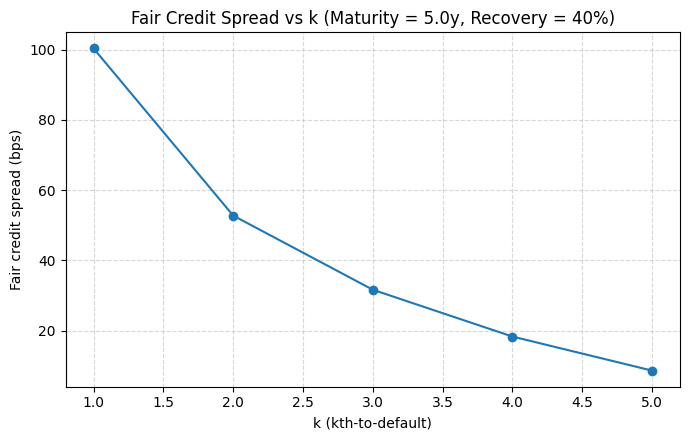

In [146]:
k_values = range(1, len(NAMES) + 1)
spreads_bps = []

for K in k_values:
    res_ct = price_kth_to_default_cds(
        k=K,
        recovery=RECOVERY,           # recovery rate
        maturities=mats,             # hazard bucket grid used for default-time inversion
        payment_days=payment_days,   # basket cashflow grid up to BASKET_T
        discounts=discount_factors,
        hazards=hazards,
        cov_matrix=cov_matrix,
        num_paths=NUM_PATHS,
    )
    spreads_bps.append(res_ct["fair_spread_bps"])

# --- Plot: Credit Spread vs k ---
plt.figure(figsize=(7, 4.5))
plt.plot(list(k_values), spreads_bps, marker="o")
plt.xlabel("k (kth-to-default)")
plt.ylabel("Fair credit spread (bps)")
plt.title(f"Fair Credit Spread vs k (Maturity = {BASKET_T}y, Recovery = {RECOVERY:.0%})")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()